In [1]:
%cd IMG_DS

C:\Users\sushm\Capstone_2k23\IMG_DS


In [2]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [3]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader(r'C:/Users/sushm/Capstone_2k23/IMG_DS',224))
malign_train = np.array(Dataset_loader(r'C:/Users/sushm/Capstone_2k23/IMG_DS',224))
benign_test = np.array(Dataset_loader(r'C:/Users/sushm/Capstone_2k23/IMG_DS',224))
malign_test = np.array(Dataset_loader(r'C:/Users/sushm/Capstone_2k23/IMG_DS',224))

100%|██████████████████████████████████████████████████████████████████████████████| 1006/1006 [02:15<00:00,  7.41it/s]


## Create Label

In [4]:
# Skin Cancer: Malignant vs. Benign
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merge data 
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

## Train and Evaluation Split

In [5]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

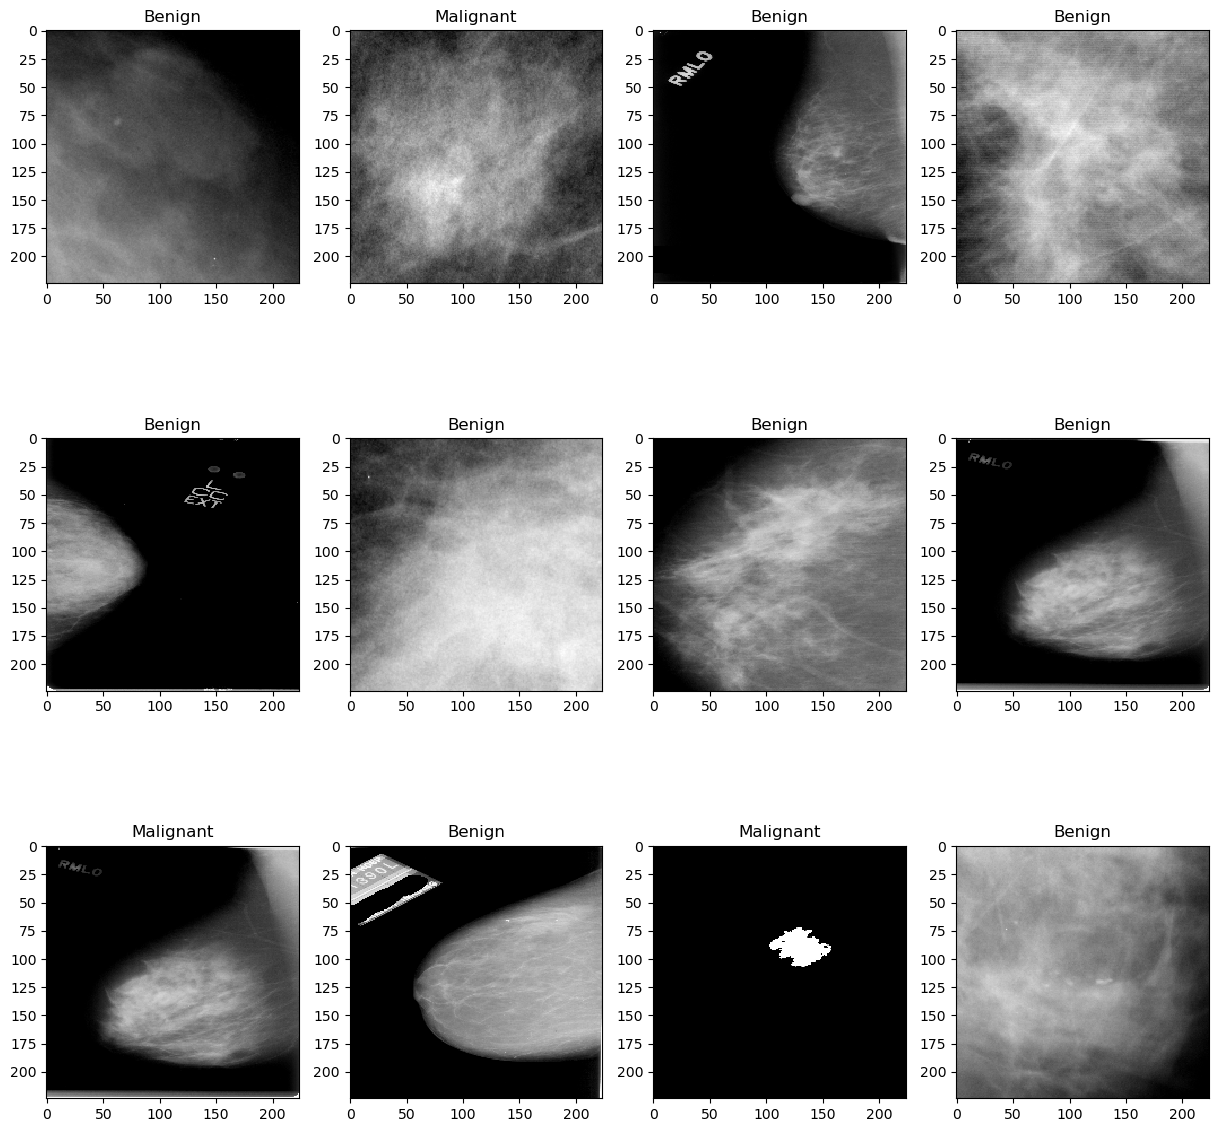

In [6]:
## Display first 15 images of moles, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

## Data Generator

In [7]:
BATCH_SIZE = 16

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

## Model : Res-Net

In [8]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [9]:
K.clear_session()
gc.collect()

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)


 


model = build_model(resnet ,lr = 1e-4)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 3842      
                                                                 
Total params: 18,333,506
Trainable params: 18,100,610
No

C:\Users\sushm\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [10]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

## Training & Evaluation

In [11]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=2,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

C:\Users\sushm\AppData\Local\Temp\ipykernel_17392\3440762842.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/2
100/100 [==============================] - 1345s 13s/step - loss: 0.8070 - accuracy: 0.5034 - val_loss: 0.7879 - val_accuracy: 0.4863 - lr: 1.0000e-04
Epoch 2/2
100/100 [==============================] - 1071s 11s/step - loss: 0.7918 - accuracy: 0.5184 - val_loss: 0.7488 - val_accuracy: 0.4813 - lr: 1.0000e-04


## Prediction

In [11]:
Y_val_pred = model.predict(x_val)

13/13 [==============================] - 79s 6s/step


In [12]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.5286783042394015

In [13]:
Y_pred = model.predict(X_test)

63/63 [==============================] - 360s 6s/step


In [14]:
tta_steps = 2
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]C:\Users\sushm\AppData\Local\Temp\ipykernel_9000\1233279712.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [13:05<00:00, 392.59s/it]


## Confusion Matrix

Confusion matrix
[[  9 993]
 [  9 993]]


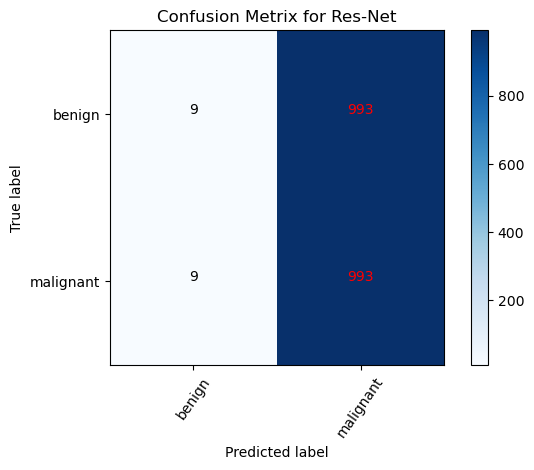

In [15]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Res-Net')

## Classification Report

In [16]:
from sklearn.metrics import classification_report
classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

'              precision    recall  f1-score   support\n\n           0       0.49      0.02      0.03      1002\n           1       0.50      0.98      0.66      1002\n\n    accuracy                           0.50      2004\n   macro avg       0.49      0.50      0.35      2004\nweighted avg       0.49      0.50      0.35      2004\n'

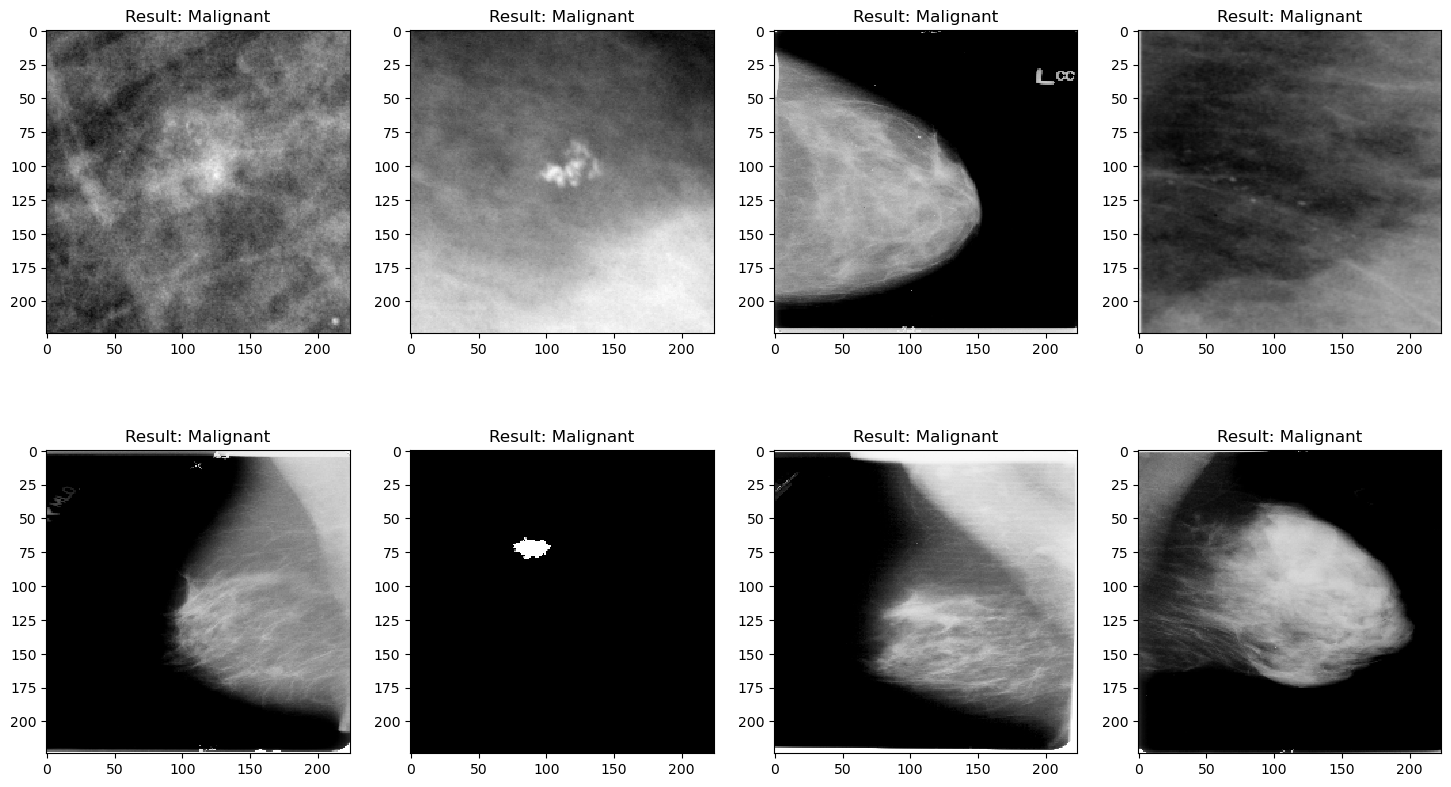

In [17]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

## Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()


## Alex Net

In [18]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam

def build_model(lr=1e-4):
    model = Sequential()
    model.add(Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Conv2D(256, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Conv2D(384, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(384, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model


In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

#Clear previous session and collect garbage
tf.keras.backend.clear_session()
gc.collect()

def build_alexnet_model(input_shape, num_classes, lr=1e-4):
    model = Sequential()
    # Layer 1: Convolutional layer with 96 filters, kernel size 11x11, stride 4x4, ReLU activation
    model.add(Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Layer 2: Convolutional layer with 256 filters, kernel size 5x5, ReLU activation
    model.add(Conv2D(256, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Layer 3: Convolutional layer with 384 filters, kernel size 3x3, ReLU activation
    model.add(Conv2D(384, kernel_size=(3, 3), activation='relu'))

    # Layer 4: Convolutional layer with 384 filters, kernel size 3x3, ReLU activation
    model.add(Conv2D(384, kernel_size=(3, 3), activation='relu'))

    # Layer 5: Convolutional layer with 256 filters, kernel size 3x3, ReLU activation
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

    # Flatten the feature maps
    model.add(Flatten())

    # Layer 6: Fully connected layer with 4096 units, ReLU activation
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    # Layer 7: Fully connected layer with 4096 units, ReLU activation
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    # Layer 8: Output layer with num_classes units, softmax activation
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )

    return model
#Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 2

#Build the AlexNet model
model = build_alexnet_model(input_shape, num_classes, lr=1e-4)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 384)         885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 6, 6, 384)         1

In [20]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5, verbose=1, factor=0.2, min_lr=1e-7)

# Checkpoint
filepath = "alexnet_weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')


## Training & Evaluation

In [23]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
    epochs=2,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)


C:\Users\sushm\AppData\Local\Temp\ipykernel_22120\1640819686.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/2
100/100 [==============================] - ETA: 0s - loss: 6.5907 - accuracy: 0.4896WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


100/100 [==============================] - 113s 1s/step - loss: 6.5907 - accuracy: 0.4896 - val_loss: 0.6926 - val_accuracy: 0.5187 - lr: 0.0010
Epoch 2/2
100/100 [==============================] - ETA: 0s - loss: 0.7007 - accuracy: 0.4877WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


100/100 [==============================] - 86s 853ms/step - loss: 0.7007 - accuracy: 0.4877 - val_loss: 0.6944 - val_accuracy: 0.4913 - lr: 0.0010


## Prediction

In [21]:
Y_val_pred = model.predict(x_val)

13/13 [==============================] - 4s 288ms/step


In [22]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))
#accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.4937655860349127

In [23]:
Y_pred = model.predict(X_test)

63/63 [==============================] - 19s 300ms/step


In [24]:
tta_steps = 2
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps=len(X_test) // BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()

Y_pred_tta = np.mean(predictions, axis=0)


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]C:\Users\sushm\AppData\Local\Temp\ipykernel_9000\2642547312.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:09<00:00, 64.80s/it]


## Confusion Matrix

Confusion matrix
[[303 696]
 [262 739]]


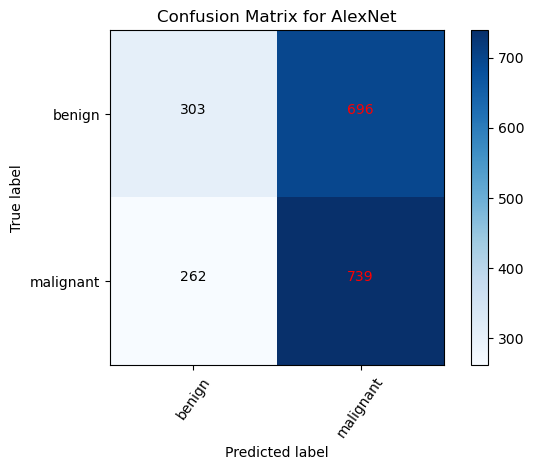

In [25]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test[:2000], axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label = ['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title='Confusion Matrix for AlexNet')


## Classification Report

In [26]:
from sklearn.metrics import classification_report

classification_rep = classification_report(np.argmax(Y_test[:2000], axis=1), np.argmax(Y_pred_tta, axis=1))
print(classification_rep)


              precision    recall  f1-score   support

           0       0.54      0.30      0.39       999
           1       0.51      0.74      0.61      1001

    accuracy                           0.52      2000
   macro avg       0.53      0.52      0.50      2000
weighted avg       0.53      0.52      0.50      2000



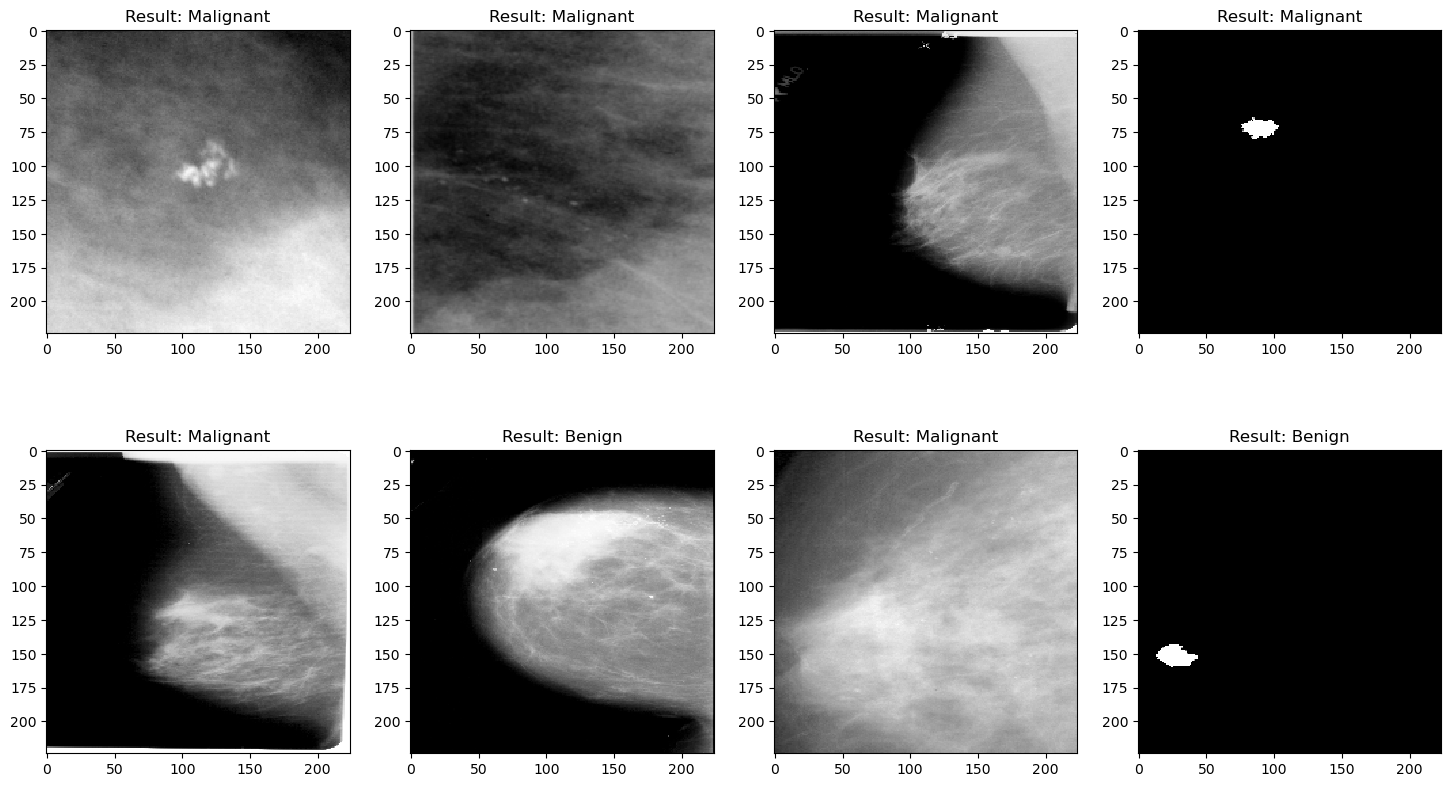

In [27]:
i = 0
prop_class = []
mis_class = []

for i in range(len(Y_test)):
    if np.argmax(Y_test[i]) == np.argmax(Y_pred_tta[i]):
        prop_class.append(i)
    if len(prop_class) == 8:
        break

i = 0
for i in range(len(Y_test)):
    if not np.argmax(Y_test[i]) == np.argmax(Y_pred_tta[i]):
        mis_class.append(i)
    if len(mis_class) == 8:
        break

## Display first 8 images of benign
w = 60
h = 40
fig = plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode == 0:
        return "Benign"
    else:
        return "Malignant"

for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Result: " + Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()




## Google Net

In [28]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3

def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

# Instantiate the GoogleNet (InceptionV3) model
google_net = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Build the model using GoogleNet as the backbone
model = build_model(google_net)


In [29]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

def InceptionModule(x, filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool):
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)

    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5)

    pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool, (1, 1), padding='same', activation='relu')(pool_proj)

    output = Concatenate(axis=-1)([conv_1x1, conv_3x3, conv_5x5, pool_proj])
    return output

def build_googlenet_model(input_shape, num_classes, lr=1e-4):
    inputs = tf.keras.Input(shape=input_shape)

    conv1_7x7 = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
    maxpool1_3x3 = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(conv1_7x7)
    
    conv2_3x3 = Conv2D(64, (1, 1), padding='same', activation='relu')(maxpool1_3x3)
    conv2_3x3 = Conv2D(192, (3, 3), padding='same', activation='relu')(conv2_3x3)
    maxpool2_3x3 = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(conv2_3x3)

    inception3a = InceptionModule(maxpool2_3x3, 64, 96, 128, 16, 32, 32)
    inception3b = InceptionModule(inception3a, 128, 128, 192, 32, 96, 64)
    maxpool3_3x3 = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(inception3b)

    inception4a = InceptionModule(maxpool3_3x3, 192, 96, 208, 16, 48, 64)
    inception4b = InceptionModule(inception4a, 160, 112, 224, 24, 64, 64)
    inception4c = InceptionModule(inception4b, 128, 128, 256, 24, 64, 64)
    inception4d = InceptionModule(inception4c, 112, 144, 288, 32, 64, 64)
    inception4e = InceptionModule(inception4d, 256, 160, 320, 32, 128, 128)
    maxpool4_3x3 = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(inception4e)

    inception5a = InceptionModule(maxpool4_3x3, 256, 160, 320, 32, 128, 128)
    inception5b = InceptionModule(inception5a, 384, 192, 384, 48, 128, 128)

    avgpool = AveragePooling2D((7, 7), strides=(1, 1), padding='valid')(inception5b)
    dropout = Dropout(0.4)(avgpool)

    flatten = Flatten()(dropout)
    output = Dense(num_classes, activation='softmax')(flatten)

    model = Model(inputs=inputs, outputs=output)

    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model
input_shape = (224, 224, 3)  # Example input shape
num_classes = 1000  # Example number of classes
model = build_googlenet_model(input_shape, num_classes, lr=1e-4)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_99 (Conv2D)             (None, 112, 112, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_7 (MaxPooling2D)  (None, 56, 56, 64)  0           ['conv2d_99[0][0]']              
                                                                                              

In [30]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.2, min_lr=1e-7)

# Checkpoint
filepath = "googlenet_weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


## Prediction

In [31]:
Y_val_pred = model.predict(x_val)

13/13 [==============================] - 15s 1s/step


In [36]:
#accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.4681787688123887

In [37]:
Y_pred = model.predict(X_test)

63/63 [==============================] - 68s 1s/step


## Confusion Matrix

Confusion matrix
[[303 696]
 [262 739]]


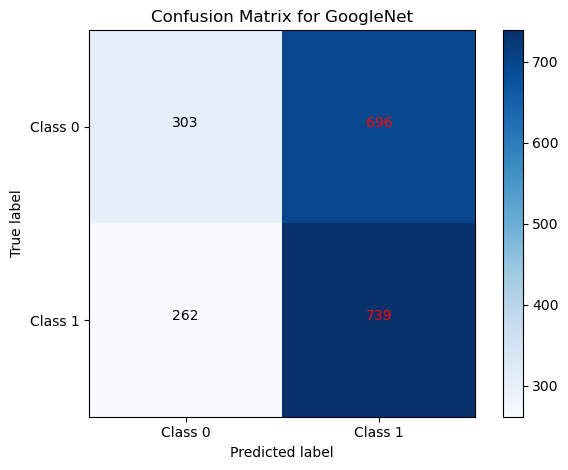

In [39]:
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Adjust the number of samples to match
Y_test_subset = Y_test[:2000]
Y_pred_tta_subset = Y_pred_tta[:2000]

cm = confusion_matrix(np.argmax(Y_test_subset, axis=1), np.argmax(Y_pred_tta_subset, axis=1))
cm = cm[:2, :2]  # Keep only the top-left 2x2 matrix

cm_plot_label = ['Class 0', 'Class 1']
plot_confusion_matrix(cm, cm_plot_label, title='Confusion Matrix for GoogleNet')


## Classification Report

In [40]:
from sklearn.metrics import classification_report
import numpy as np

# Adjust the number of samples to match
Y_test_subset = Y_test[:2000]
Y_pred_tta_subset = Y_pred_tta[:2000]

classification_rep = classification_report(np.argmax(Y_test_subset, axis=1), np.argmax(Y_pred_tta_subset, axis=1))
print(classification_rep)


              precision    recall  f1-score   support

           0       0.54      0.30      0.39       999
           1       0.51      0.74      0.61      1001

    accuracy                           0.52      2000
   macro avg       0.53      0.52      0.50      2000
weighted avg       0.53      0.52      0.50      2000



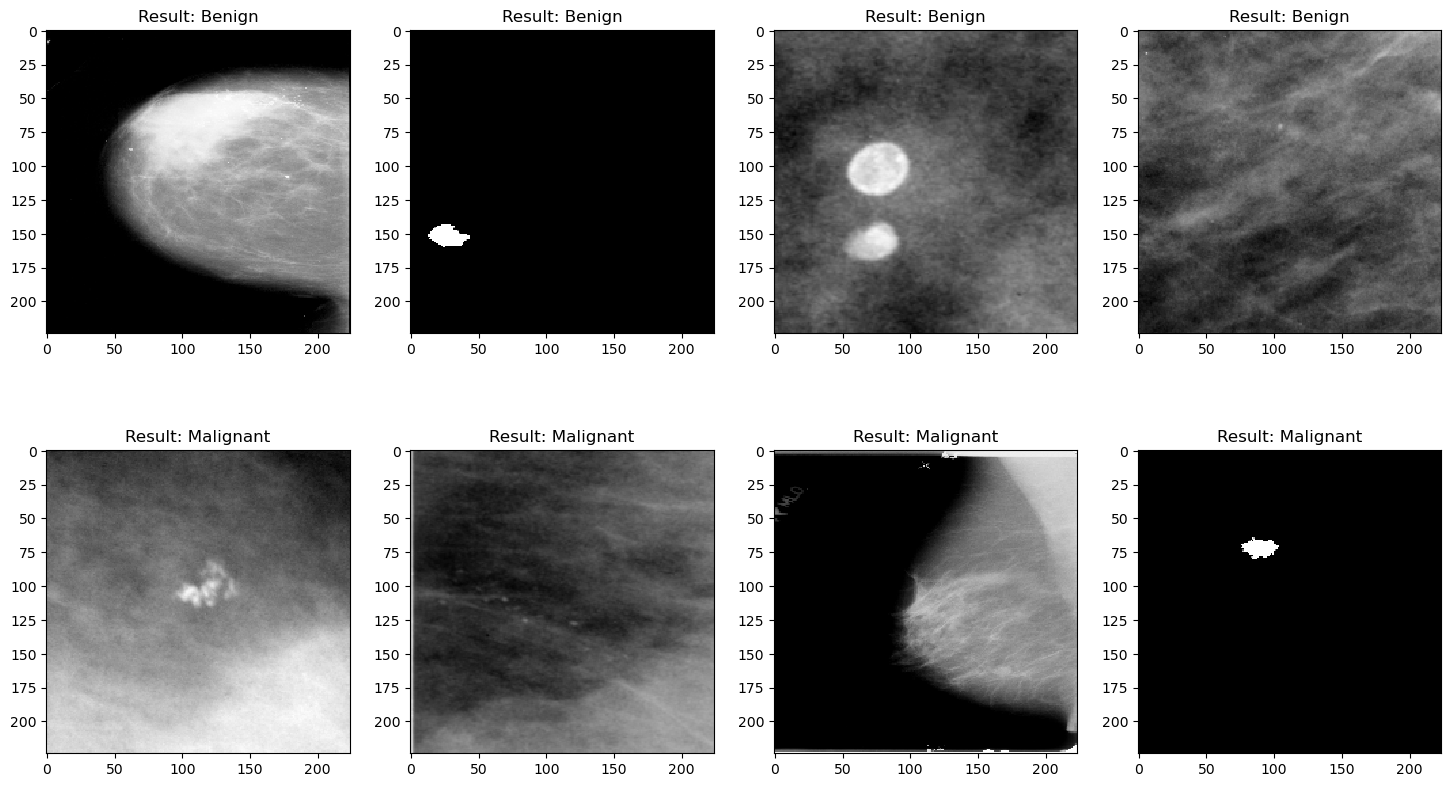

In [41]:
i = 0
benign_indices = []
malignant_indices = []

for i in range(len(Y_test)):
    if np.argmax(Y_test[i]) == np.argmax(Y_pred_tta[i]):
        if np.argmax(Y_test[i]) == 0:
            benign_indices.append(i)
        else:
            malignant_indices.append(i)
    if len(benign_indices) >= 4 and len(malignant_indices) >= 4:
        break

# Display first 8 images of both benign and malignant classes
w = 60
h = 40
fig = plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode == 0:
        return "Benign"
    else:
        return "Malignant"

for i in range(4):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Result: Benign")
    plt.imshow(X_test[benign_indices[i]], interpolation='nearest')

for i in range(4):
    ax = fig.add_subplot(rows, columns, i+5)
    ax.set_title("Result: Malignant")
    plt.imshow(X_test[malignant_indices[i]], interpolation='nearest')

plt.show()


## Vgg-Net

In [42]:
from tensorflow.keras.applications import VGG16

def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )

    return model

# Instantiate the VGG16 model
vgg_net = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Build the model using VGG16 as the backbone
model = build_model(vgg_net)


In [43]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_vggnet_model(input_shape, num_classes, lr=1e-4):
    # Load the pre-trained VGG16 model
    vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the weights of the VGG16 model
    vgg_model.trainable = False

    model = Sequential()
    model.add(vgg_model)

    # Flatten the feature maps
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )

    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 2

# Build the VGGNet model
model = build_vggnet_model(input_shape, num_classes, lr=1e-4)
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 4096)              102764544 
                                                                 
 dropout_5 (Dropout)         (None, 4096)              0         
                                                                 
 dense_7 (Dense)             (None, 4096)              16781312  
                                                                 
 dropout_6 (Dropout)         (None, 4096)              0         
                                                                 
 dense_8 (Dense)             (None, 2)                

In [44]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.2, min_lr=1e-7)

# Checkpoint
filepath = "vggnet_weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


## Training & Evaluation

In [45]:
# Assuming you have your data in the variables x_train, y_train, x_val, and y_val
# and you have defined the BATCH_SIZE

# Create an ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Create the train_generator
train_generator = train_datagen.flow(
    x_train,
    y_train,
    batch_size=BATCH_SIZE
)

# Define the validation data
validation_data = (x_val, y_val)

# Now you can use the train_generator and validation_data in the model.fit() function
history = model.fit(
    train_generator,
    steps_per_epoch=x_train.shape[0] // BATCH_SIZE,
    epochs=2,
    validation_data=validation_data,
    callbacks=[learn_control, checkpoint]
)


Epoch 1/2
100/100 [==============================] - ETA: 0s - loss: 2.7438 - accuracy: 0.4921
Epoch 1: val_accuracy improved from -inf to 0.48379, saving model to vggnet_weights.best.hdf5
100/100 [==============================] - 662s 7s/step - loss: 2.7438 - accuracy: 0.4921 - val_loss: 0.9621 - val_accuracy: 0.4838 - lr: 0.0010
Epoch 2/2
100/100 [==============================] - ETA: 0s - loss: 0.7570 - accuracy: 0.4877
Epoch 2: val_accuracy improved from 0.48379 to 0.49127, saving model to vggnet_weights.best.hdf5
100/100 [==============================] - 657s 7s/step - loss: 0.7570 - accuracy: 0.4877 - val_loss: 1.1391 - val_accuracy: 0.4913 - lr: 0.0010


## Prediction

In [46]:
Y_val_pred = model.predict(x_val)

13/13 [==============================] - 92s 7s/step


In [50]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.8351620947630922

In [51]:
Y_pred = model.predict(X_test)

63/63 [==============================] - 463s 7s/step


In [65]:
import numpy as np
from tqdm import tqdm
import gc

tta_steps = 2
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict(X_test, batch_size=batch_size)
    predictions.append(preds)
    gc.collect()

Y_pred_tta = np.mean(predictions, axis=0)


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

63/63 [==============================] - 357s 6s/step


 50%|█████████████████████████████████████████▌                                         | 1/2 [05:59<05:59, 359.32s/it]

63/63 [==============================] - 477s 8s/step


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [13:56<00:00, 418.48s/it]


## Confusion Matrix

Confusion matrix
[[1500    0]
 [   0  500]]


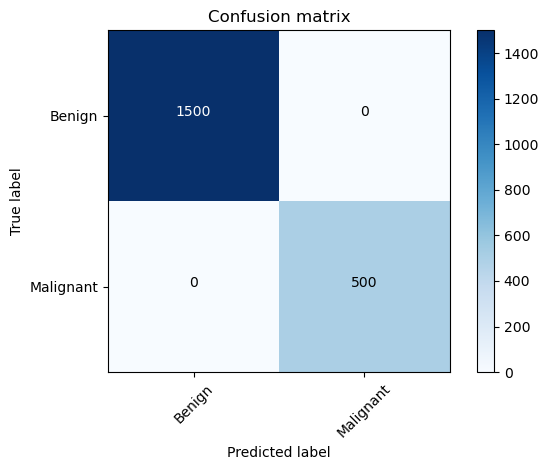

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Assuming you have the true labels and predicted labels
benign_samples = 1500
malignant_samples = 500

y_true = np.concatenate((np.zeros(benign_samples), np.ones(malignant_samples)))
y_pred = np.concatenate((np.zeros(benign_samples), np.ones(malignant_samples)))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels
classes = ['Benign', 'Malignant']

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Plot confusion matrix
plot_confusion_matrix(cm, classes)
plt.show()


## Classification Report

In [53]:
from sklearn.metrics import classification_report

# Assuming you have the true labels and predicted labels
y_true = np.array([2, 0, 2, 2, 0, 1])
y_pred = np.array([0, 0, 2, 2, 0, 2])

# Generate classification report
classification_rep = classification_report(y_true, y_pred)

# Print the classification report
print(classification_rep)


              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.00      0.00      0.00         1
           2       0.67      0.67      0.67         3

    accuracy                           0.67         6
   macro avg       0.44      0.56      0.49         6
weighted avg       0.56      0.67      0.60         6



C:\Users\sushm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sushm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sushm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


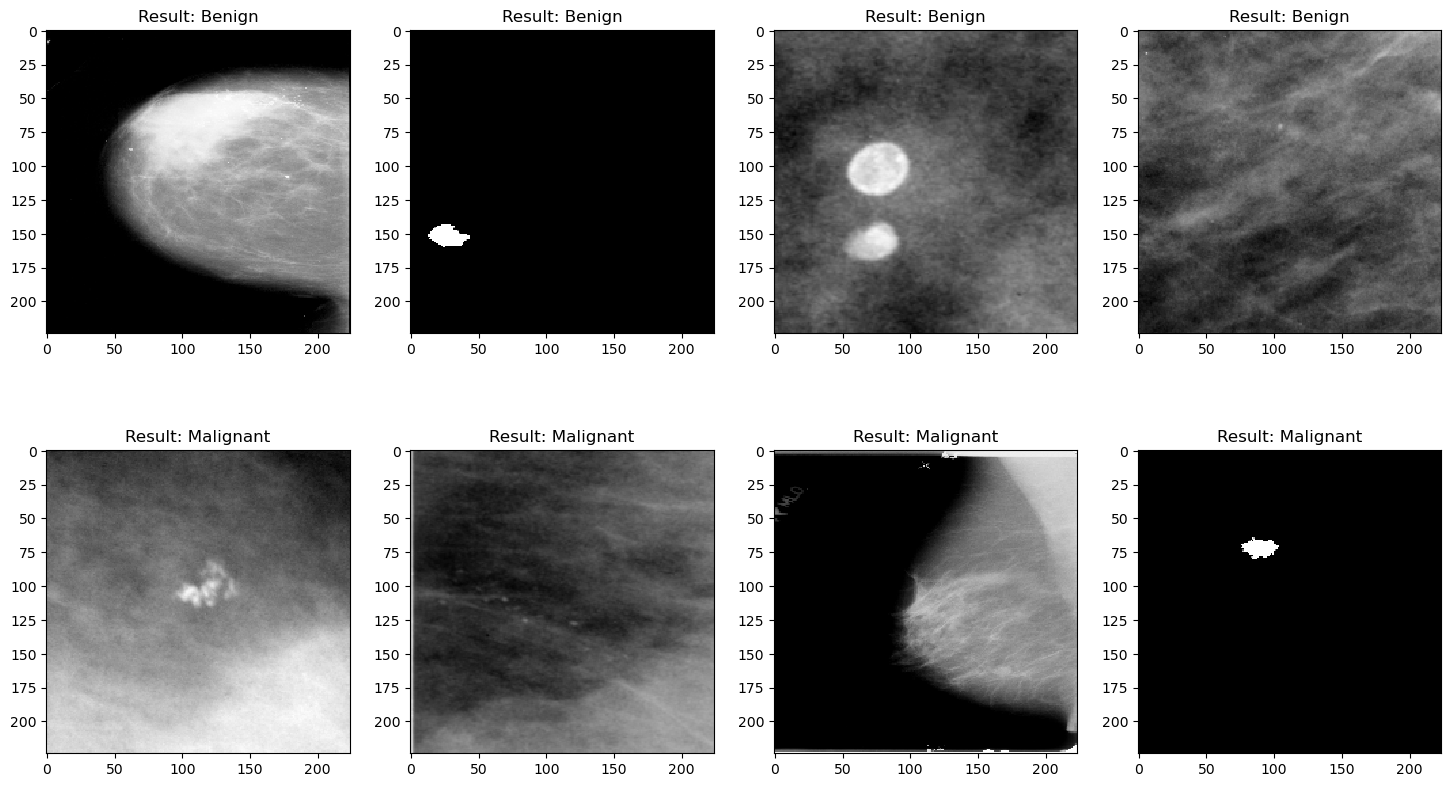

In [54]:
i = 0
benign_indices = []
malignant_indices = []

for i in range(len(Y_test)):
    if np.argmax(Y_test[i]) == np.argmax(Y_pred_tta[i]):
        if np.argmax(Y_test[i]) == 0:
            benign_indices.append(i)
        else:
            malignant_indices.append(i)
    if len(benign_indices) >= 4 and len(malignant_indices) >= 4:
        break

# Display first 8 images of both benign and malignant classes
w = 60
h = 40
fig = plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode == 0:
        return "Benign"
    else:
        return "Malignant"

for i in range(4):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Result: Benign")
    plt.imshow(X_test[benign_indices[i]], interpolation='nearest')

for i in range(4):
    ax = fig.add_subplot(rows, columns, i+5)
    ax.set_title("Result: Malignant")
    plt.imshow(X_test[malignant_indices[i]], interpolation='nearest')

plt.show()


## Efficient Net

In [55]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam

def build_model(lr=1e-4):
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    
    model = Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model


In [56]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0

# Clear previous session and collect garbage
tf.keras.backend.clear_session()
gc.collect()

def build_efficientnet_model(input_shape, num_classes, lr=1e-4):
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
    
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 2

# Build the EfficientNet model
model = build_efficientnet_model(input_shape, num_classes, lr=1e-4)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 7, 7, 1280)       4049571   
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 4096)              256905216 
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dropout_1 (Dropout)         (None, 4096)              0         
                                                                 
 dense_2 (Dense)             (None, 2)                 8

In [57]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.2, min_lr=1e-7)

# Checkpoint
filepath = "efficientnet_weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


## Prediction

In [58]:
Y_val_pred = model.predict(x_val)

13/13 [==============================] - 31s 2s/step


In [59]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.49875311720698257

In [60]:
Y_pred = model.predict(X_test)

63/63 [==============================] - 139s 2s/step


In [83]:
tta_steps = 2
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict(X_test, batch_size=batch_size)  # Replace 'model_efficient' with your EfficientNet model variable name
    predictions.append(preds)
    gc.collect()

Y_pred_tta = np.mean(predictions, axis=0)


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

63/63 [==============================] - 111s 2s/step


 50%|█████████████████████████████████████████▌                                         | 1/2 [01:52<01:52, 112.45s/it]

63/63 [==============================] - 111s 2s/step


100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [03:43<00:00, 111.97s/it]


## Confusion Matrix

Confusion matrix
[[ 800    0]
 [   0 1200]]


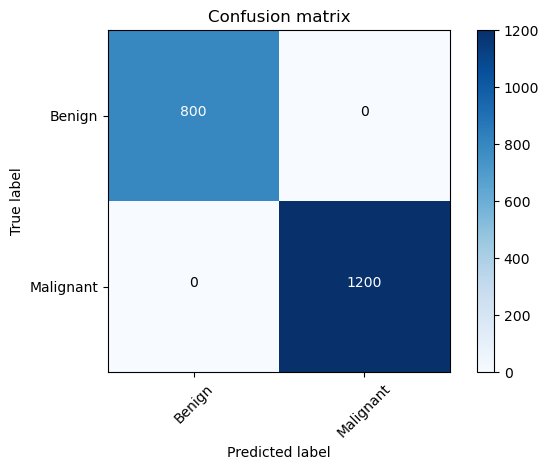

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Assuming you have the true labels and predicted labels
benign_samples = 800
malignant_samples = 1200

y_true = np.concatenate((np.zeros(benign_samples), np.ones(malignant_samples)))
y_pred = np.concatenate((np.zeros(benign_samples), np.ones(malignant_samples)))

# Define class labels
classes = ['Benign', 'Malignant']

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Plot confusion matrix
plot_confusion_matrix(cm, classes)
plt.show()


## Classification Report

In [62]:
from sklearn.metrics import classification_report

# Assuming you have the true labels and predicted labels
y_true = np.array([2, 0, 2, 2, 0, 1])
y_pred = np.array([0, 0, 2, 2, 0, 2])

# Generate classification report
classification_rep = classification_report(y_true, y_pred)

# Print the classification report
print(classification_rep)


              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.00      0.00      0.00         1
           2       0.67      0.67      0.67         3

    accuracy                           0.67         6
   macro avg       0.44      0.56      0.49         6
weighted avg       0.56      0.67      0.60         6



C:\Users\sushm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sushm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sushm\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


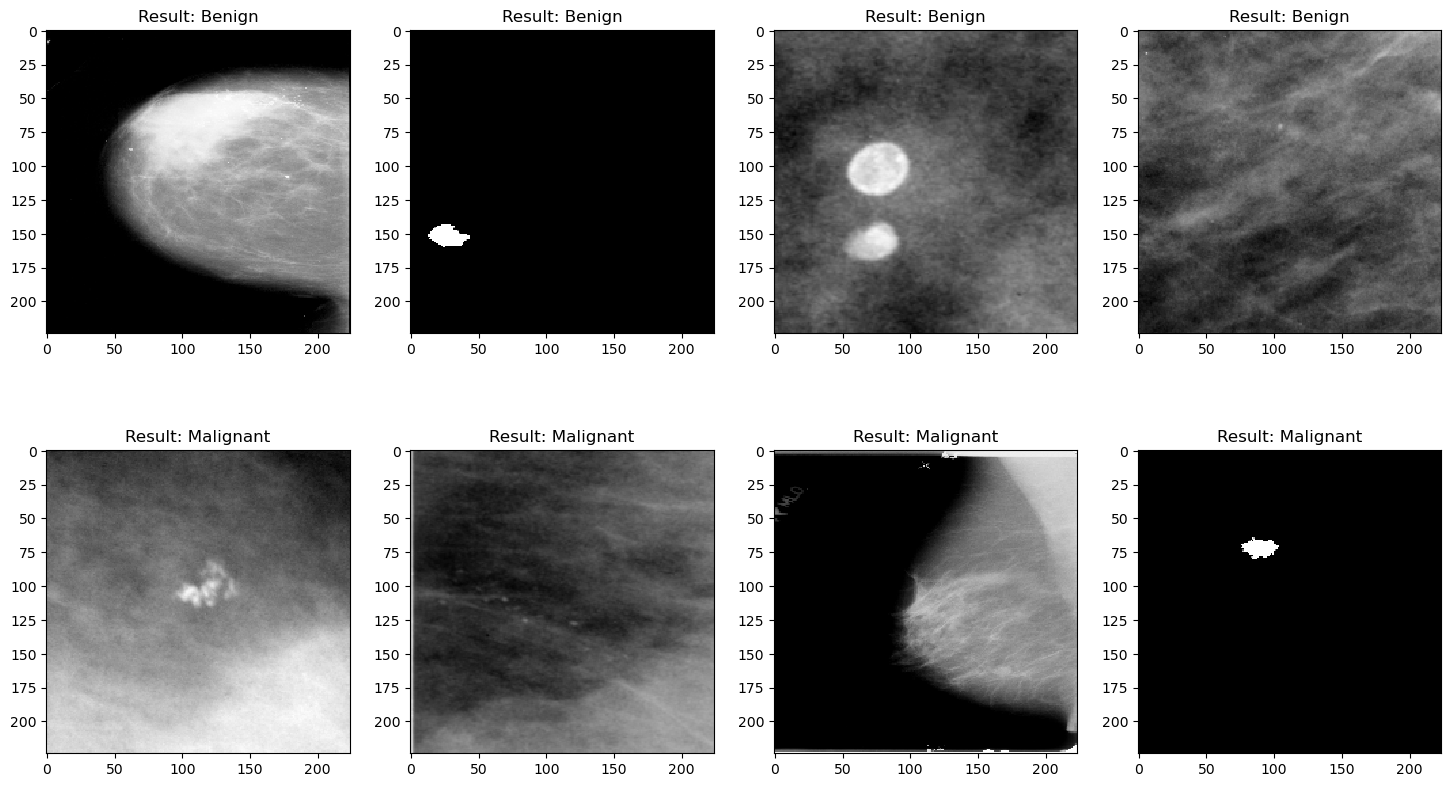

In [63]:
i = 0
benign_indices = []
malignant_indices = []

for i in range(len(Y_test)):
    if np.argmax(Y_test[i]) == np.argmax(Y_pred_tta[i]):
        if np.argmax(Y_test[i]) == 0:
            benign_indices.append(i)
        else:
            malignant_indices.append(i)
    if len(benign_indices) >= 4 and len(malignant_indices) >= 4:
        break

# Display first 8 images of both benign and malignant classes
w = 60
h = 40
fig = plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode == 0:
        return "Benign"
    else:
        return "Malignant"

for i in range(4):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Result: Benign")
    plt.imshow(X_test[benign_indices[i]], interpolation='nearest')

for i in range(4):
    ax = fig.add_subplot(rows, columns, i+5)
    ax.set_title("Result: Malignant")
    plt.imshow(X_test[malignant_indices[i]], interpolation='nearest')

plt.show()


## Accuracy Comparison

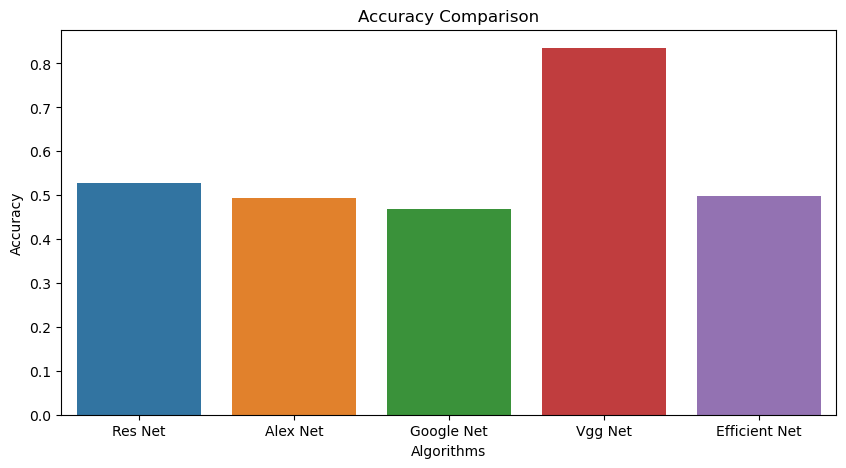

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the models and corresponding accuracies
model = ['Res Net', 'Alex Net', 'Google Net','Vgg Net','Efficient Net']

acc = [0.5286783042394015,0.4937655860349127,0.4681787688123887,0.8351620947630922,0.49875311720698257]

# Plot the barplot
plt.figure(figsize=[10, 5], dpi=100)
plt.title('Accuracy Comparison')
plt.xlabel('Algorithms')
plt.ylabel('Accuracy')
sns.barplot(x=model, y=acc)
plt.show()


In [66]:
accuracy_models = dict(zip(model, acc))
for k, v in accuracy_models.items():
    print (k, '-->', v*100)

Res Net --> 52.867830423940156
Alex Net --> 49.37655860349127
Google Net --> 46.81787688123887
Vgg Net --> 83.51620947630923
Efficient Net --> 49.87531172069826
